# Problem 5

As mentioned on campuswire, we use RTX8000 instead of TPU pod

The Resnet50 implementation that we will use in this assignment is from this [github repo](https://github.com/akamaster/pytorch_resnet_cifar10)

## Part 1

Calculate the coefficient of variation of TTA for both the hardware configurations. Compare the value you obtain with that reported in Table 3(a) in the paper by Coleman et al for Resnet-50, 1xTPU.

In [78]:
import statistics 

# For V100, we get the following times (in seconds)
v100 = [1521.4231295585632, 1474.9738330841064, 1508.977163553238, 1562.7284395694733, 1621.5581138134003]
rtx8000 = [2124.088829755783, 2146.84157538414, 2207.3559110164642, 2129.880913257599, 2368.68722820282]

# To calculate the coefficient of variation, we use the variance over the mean. 
print(f"Coefficient of variation for V100: {statistics.variance(v100)/statistics.mean(v100)}")
print(f"Coefficient of variation for RTX8000: {statistics.variance(rtx8000)/statistics.mean(rtx8000)}")


Coefficient of variation for V100: 2.0616719959379735
Coefficient of variation for RTX8000: 4.772241164588077


I'm not sure if we can really compare the RTX8000 or the V100 with a TPU, but the coefficients of variation seem to be in the same range. 

We can also see that all of the runs achieved the target accuracy of 92%. I also include the training information in the submission. 

## Part 2

Collect 5 images from the wild for each of the 10 categories in CIFAR10 and manually label them. Again in a group of 5 students, each one of you can collect 5 images for 2 categories. In this way each one of you need to collect only 10 images (5 for each of the 2 categories that you choose). These images should not be from CIFAR10 dataset. Next test the trained models for these 50 images. What is the accuracy obtained from each of the 10 trained models ? Quantify the mean and standard deviation of accuracy obtained using the 10 models for TPU and the 10 models for V100.

In [125]:
import glob
import itertools

test_data_path = "custom_dataset"
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))
    # classes.append(data_path.split('/')[-1]) 
# est_image_paths = list(flatten(test_image_paths))
test_image_paths = list(itertools.chain(*test_image_paths))

In [126]:
import cv2
from torch.utils.data import Dataset
from torchvision import transforms

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_to_idx = {x:i for i, x in enumerate(classes)}

class TestDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
test_transformation = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32)), normalize])

test_dataset = TestDataset(test_image_paths, test_transformation)
# print('The shape of tensor for 50th image in train dataset: ',test_dataset)
# print('The label for 50th image in train dataset: ',test_dataset)
len(test_dataset)

from torch.utils.data import DataLoader
testloader = DataLoader(
    test_dataset, batch_size=5, shuffle=True
)

In [127]:
import sys
import os
from resnet import ResNet, BasicBlock
import torch

def resnet50():
    return ResNet(BasicBlock, [8, 8, 8])


models = {
    "v100": [],
    "rtx8000": []
}

# Load the models
for gpu_model in ['v100', 'rtx8000']:
    PATH = os.path.join("./problem5", gpu_model)
    experiments = os.listdir(PATH)
    for experiment in experiments:
        model_path = os.path.join(PATH, experiment, "models", 'resnet50_final.pth')
        net = resnet50()
        net.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
        models[gpu_model].append(net.eval())

correct = 0
total = 0
net = models['v100'][0]
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct // total} %')


Accuracy of the network on the 50 test images: 76 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


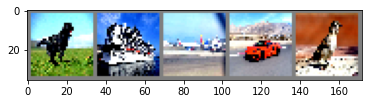

GroundTruth: 	     dog    ship   plane     car    bird
Predicted: 	     dog    ship   plane   truck    bird


In [174]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \t', ' '.join('%7s' % classes[labels[j]] for j in range(len(labels))))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: \t', ' '.join('%7s' % classes[predicted[j]] for j in range(len(predicted))))

## Part 3
Measure the GPU utilization using nvidia-smi while training with V100 and report both the time series of GPU core and memory utilization and their average over a period of 3 mins of training. Is the GPU utilization close to 100% ?

* I added this functionality to the training script, so every experiment has its own GPU info time series. We can see that they all run for 180 seconds (3 minutes)

The mean for both metrics are: 


gpu_core_utilization      0.598649
gpu_memory_utilization    0.242336
dtype: float64

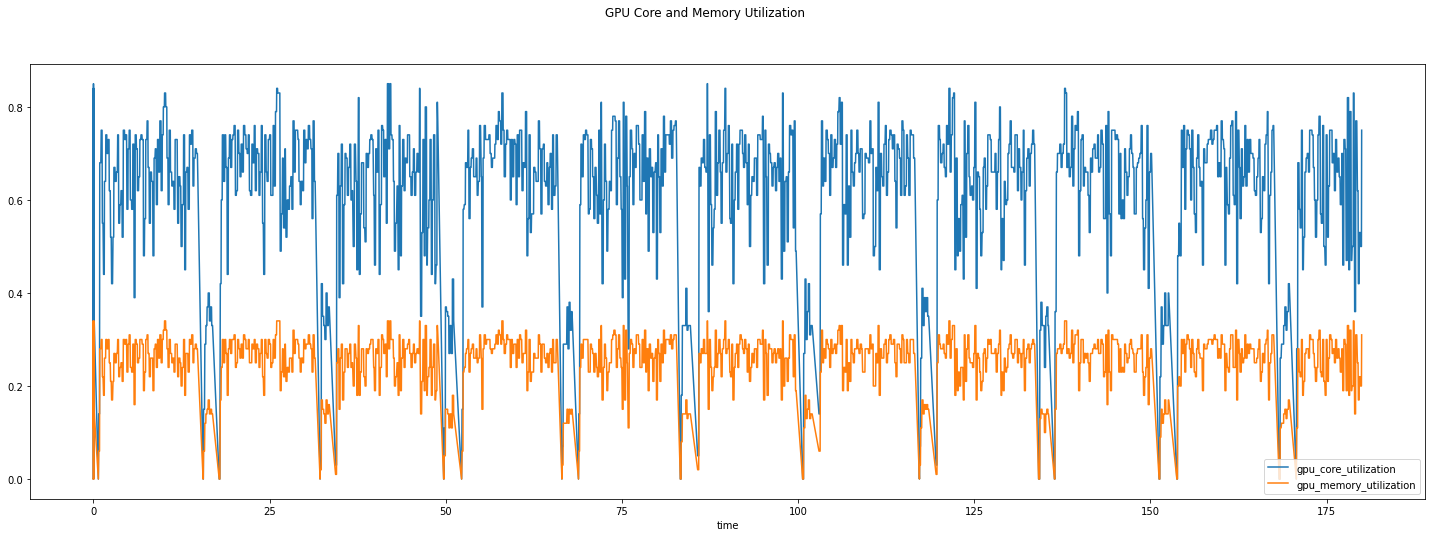

In [183]:
import pandas as pd

gpu_dfs = []
PATH = os.path.join("./problem5", 'v100')
experiments = os.listdir(PATH)
for experiment in experiments:
    df_path = os.path.join(PATH, experiment, 'GPU_info.csv')
    gpu_dfs.append(pd.read_csv(df_path, index_col=False))

experiment_number = 4
df = gpu_dfs[experiment_number]
fig, axs = plt.subplots(figsize=(25, 8))
fig.suptitle('GPU Core and Memory Utilization')
df[['gpu_core_utilization', 'gpu_memory_utilization']] /= 100
df.plot(x='time', y=['gpu_core_utilization', 'gpu_memory_utilization'], ax=axs).legend(loc='lower right')
print("The mean for both metrics are: ")
df[['gpu_core_utilization', 'gpu_memory_utilization']].mean()

## Part 4

If the GPU utilization is low, what can you do to increase the GPU utilization? Try your trick(s) and report if you are successful or not in driving GPU utilization close to 100%.

If the GPU utilization is low, then we could increase the batch size to increase the utilization. I already used a relatively large batch size of 128, and the utilization of 77% is not bad, but I could try to train a network with batch size 32 and another with batch size 256 to see if my hypothesis of changing the batch size was correct. 